In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd    # Importing the pandas
import numpy as np      # Importing the numpy library
import os               # Importing the os module for interacting with the operating system
import seaborn as sns   # Importing the seaborn library for visualization
import matplotlib.pyplot as plt # Importing the matplotlib library for visualizations
import librosa                  # Importing the librosa library for audio analysis
import librosa.display          # Importing the librosa.display module for audio visualization
from IPython.display import Audio # Importing the Audio class from IPython.display module for audio playback
import librosa.display
from scipy.signal import cwt, morlet                     # Wavelet Transform

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras                       # Importing keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


import warnings                   # Importing the warnings module to control warning messages
warnings.filterwarnings('ignore') # Disabling warning messages in the output

In [3]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Emotion in Speech/AudioWAV/'):
  for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        part=filename.split('_')
        if part[2] == 'SAD':
          labels.append('sad')
        elif part[2] == 'ANG':
          labels.append('angry')
        elif part[2] == 'DIS':
          labels.append('disgust')
        elif part[2] == 'FEA':
          labels.append('fear')
        elif part[2] == 'HAP':
          labels.append('happy')
        elif part[2] == 'NEU':
          labels.append('neutral')
        else:
          labels.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(labels, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(paths, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,neutral,/content/drive/MyDrive/Emotion in Speech/Audio...
1,happy,/content/drive/MyDrive/Emotion in Speech/Audio...
2,disgust,/content/drive/MyDrive/Emotion in Speech/Audio...
3,fear,/content/drive/MyDrive/Emotion in Speech/Audio...
4,disgust,/content/drive/MyDrive/Emotion in Speech/Audio...


Load the datasets

In [4]:
len(paths)

7442

In [5]:
labels[:5]


['neutral', 'happy', 'disgust', 'fear', 'disgust']

In [6]:
Crema_df['Emotions'].value_counts()

happy      1271
disgust    1271
fear       1271
sad        1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64

**Exploratory Data Analysis**

---



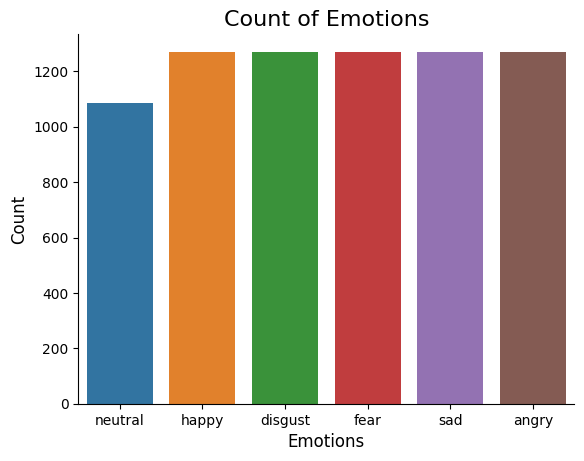

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=Crema_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def spectrogram(data, sr, emotion):
    # Compute the wavelet transform
    scales = range(1, 128)  # You can adjust the range of scales as per your requirement
    X = cwt(data, morlet, scales)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Wavelet Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='linear')  # Use 'linear' for y-axis to represent the frequency bins
    plt.colorbar()

    # Print the spectrogram shape
    print("Wavelet Spectrogram shape:", Xdb.shape)

In [ ]:
def waveplot(data, sr, emotion):
  # Print the waveform shape
    print("Waveform shape:", data.shape)
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    plt.plot(data)
    plt.xlabel('Time', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.show()

Waveform shape: (57388,)


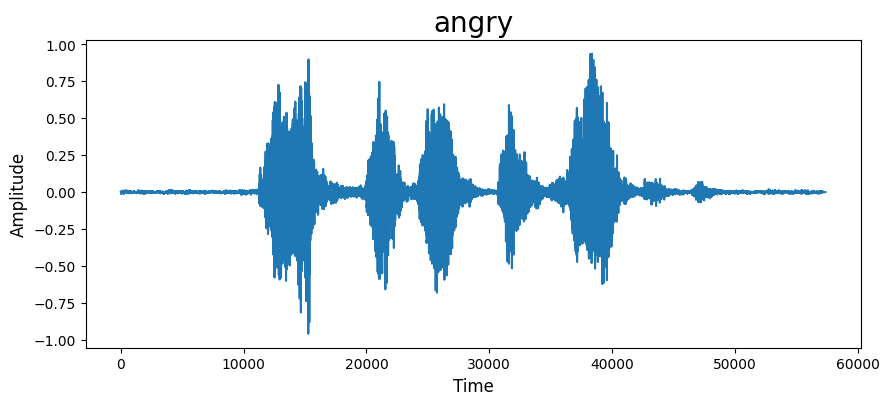

Wavelet Spectrogram shape: (127, 57388)


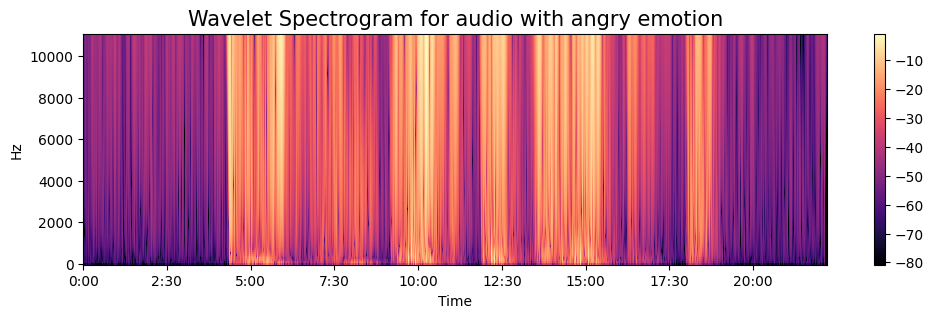

In [ ]:
emotion = 'angry'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Waveform shape: (53709,)


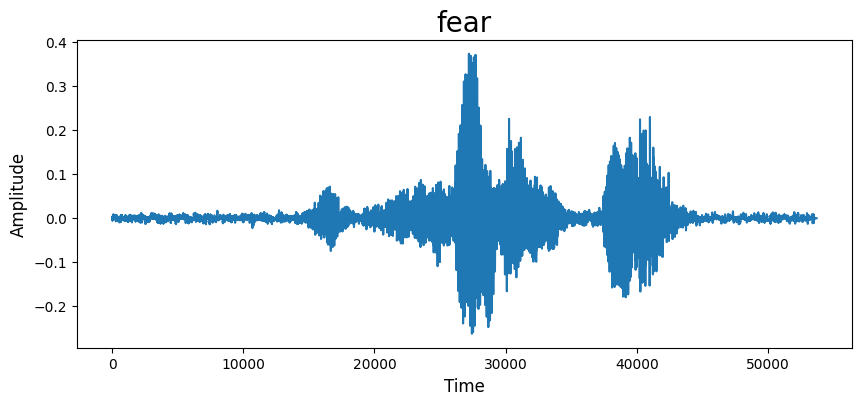

Wavelet Spectrogram shape: (127, 53709)


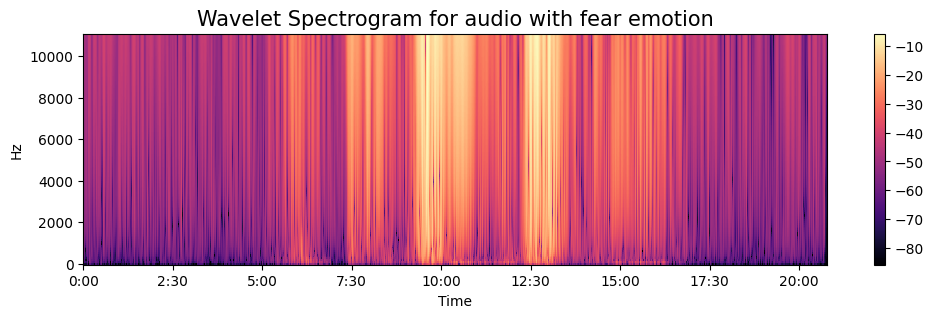

In [ ]:
emotion = 'fear'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[13]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Waveform shape: (50766,)


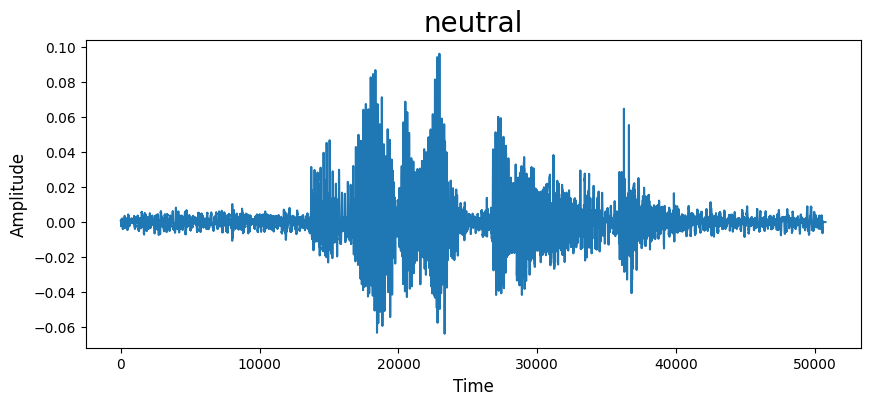

Wavelet Spectrogram shape: (127, 50766)


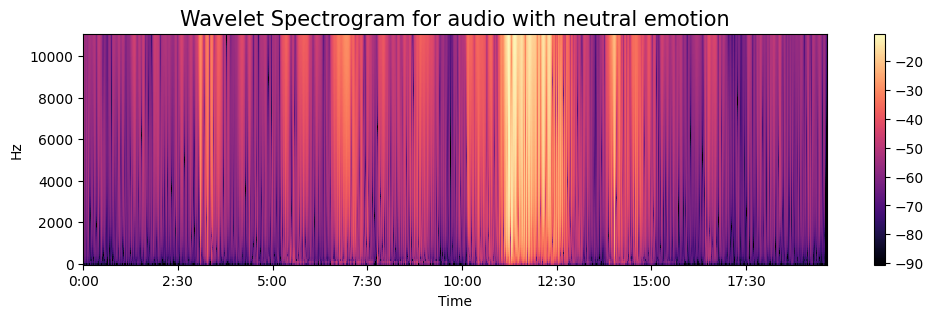

In [ ]:
emotion = 'neutral'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[45]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Waveform shape: (61803,)


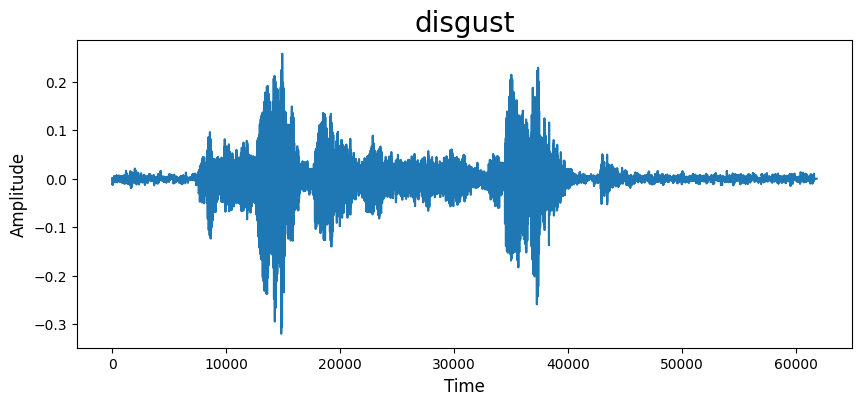

Wavelet Spectrogram shape: (127, 61803)


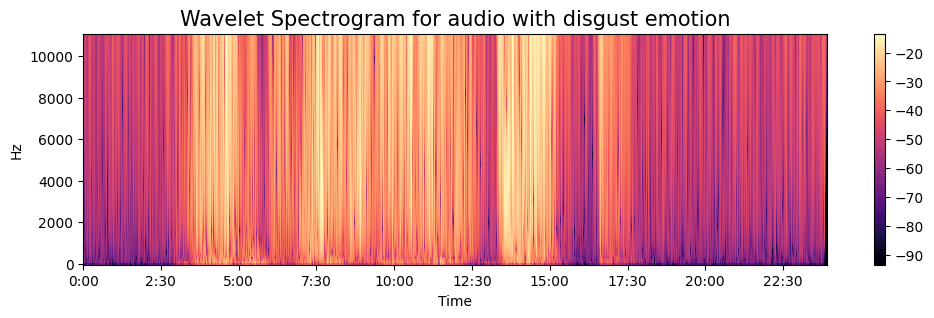

In [ ]:
emotion = 'disgust'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Waveform shape: (52237,)


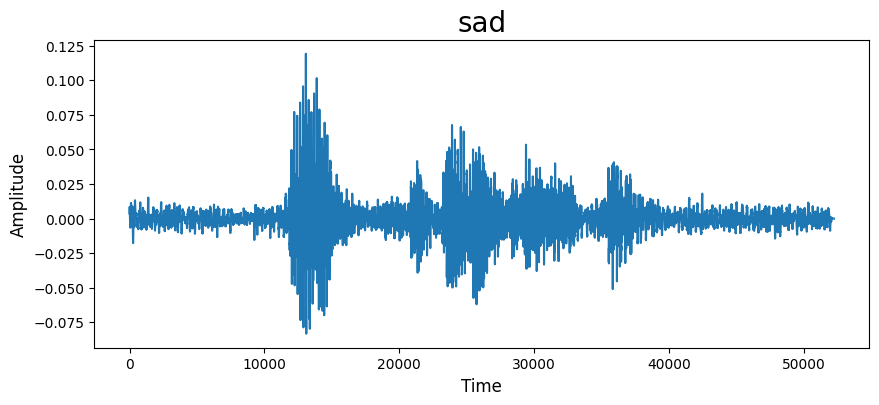

Wavelet Spectrogram shape: (127, 52237)


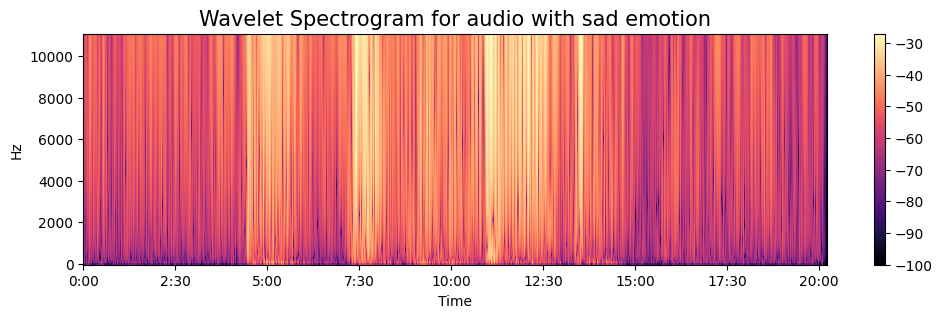

In [ ]:
emotion = 'sad'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[100]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Waveform shape: (51502,)


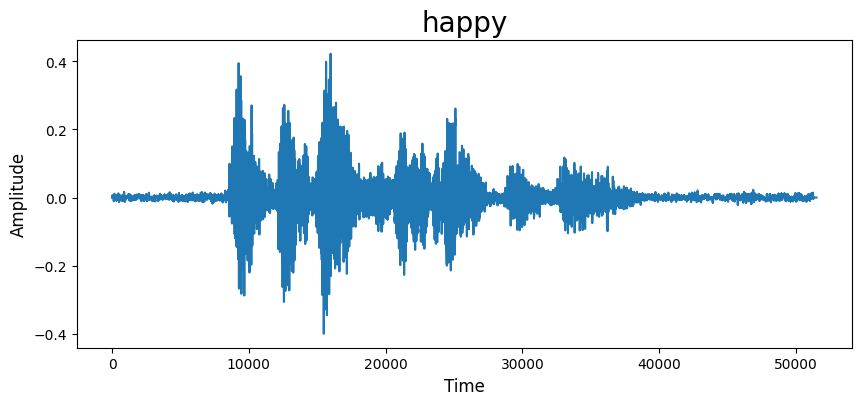

Wavelet Spectrogram shape: (127, 51502)


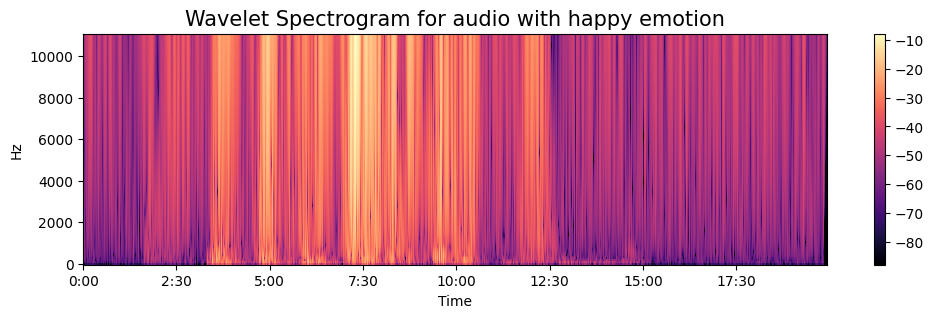

In [ ]:
emotion = 'happy'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[209]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

**Data Augmentation**

---

In [ ]:
def noise(data, noise_factor=0.035):
    # Generate random noise amplitude within specified factor
    noise_amp = noise_factor * np.random.uniform() * np.amax(data)
    # Add Gaussian noise to the data
    noisy_data = data + noise_amp * np.random.normal(size=data.shape)
    return noisy_data

def stretch(data, rate=0.7):
    # Stretch the data using time stretching
    stretched_data = librosa.effects.time_stretch(data, rate=rate)
    return stretched_data

def pitch(data, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def amplitude_scaling(data, scaling_factor=0.7):
    # Scale the amplitude of the data by the specified factor
    scaled_data = data * scaling_factor
    return scaled_data


In [ ]:
# taking a example & checking for augmentation techniques.
emotion = 'angry'
path = np.array(Crema_df['Path'][Crema_df['Emotions']==emotion])[750]
data, sample_rate = librosa.load(path)

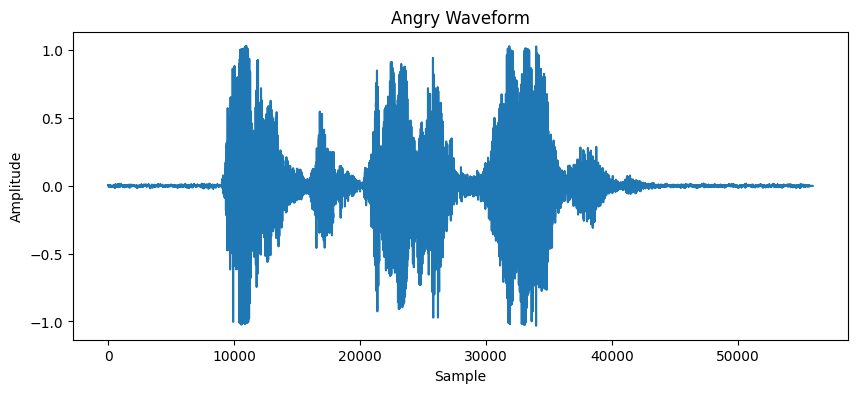

In [ ]:
# Original Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Angry Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()



# Play the audio
Audio(data, rate=sample_rate)

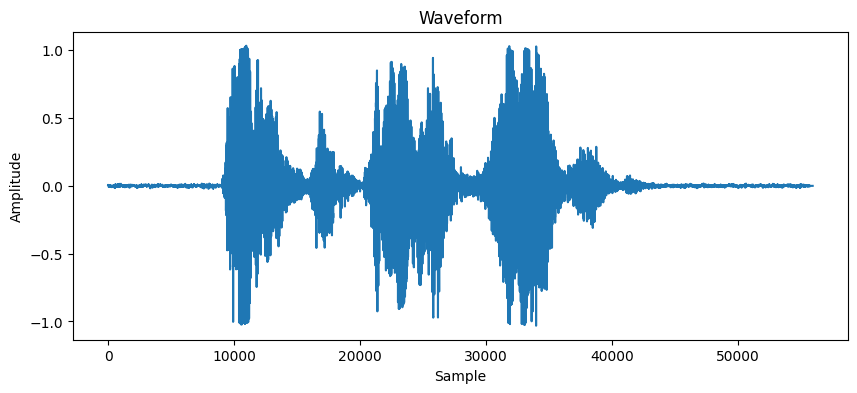

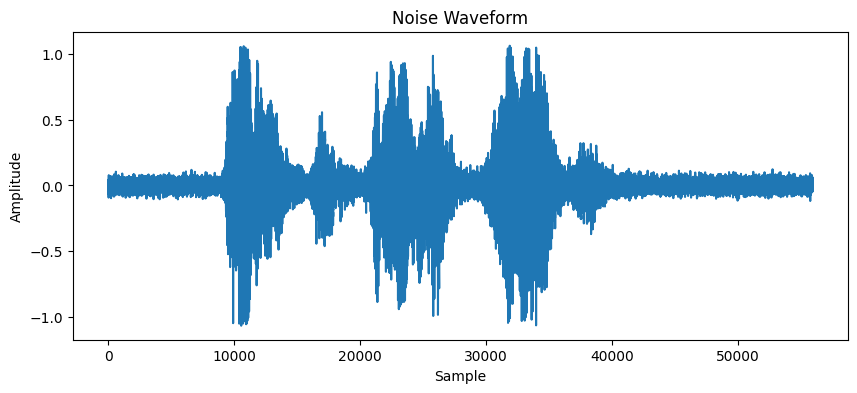

In [ ]:
# Noisy Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


# Play the audio
Ag= noise(data)
Audio(Ag, rate=sample_rate)

# Noisy Data
plt.figure(figsize=(10, 4))
plt.plot(Ag)
plt.title('Noise Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

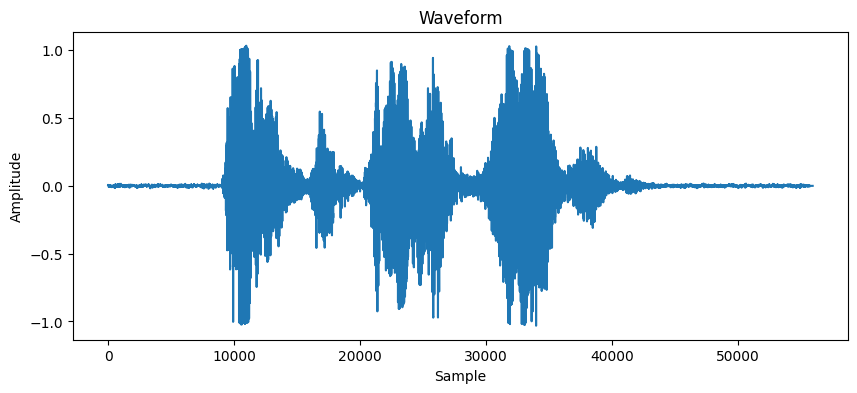

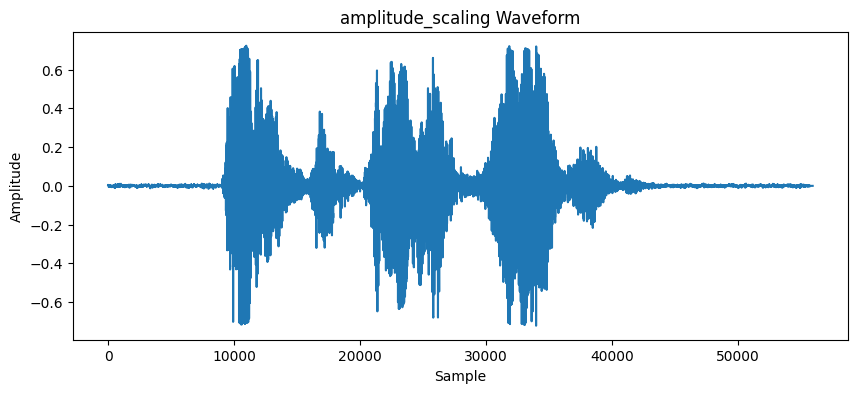

In [ ]:
# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


# Play the audio
Ag_sc= amplitude_scaling(data)
Audio(Ag_sc, rate=sample_rate)

# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(Ag_sc)
plt.title('amplitude_scaling Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

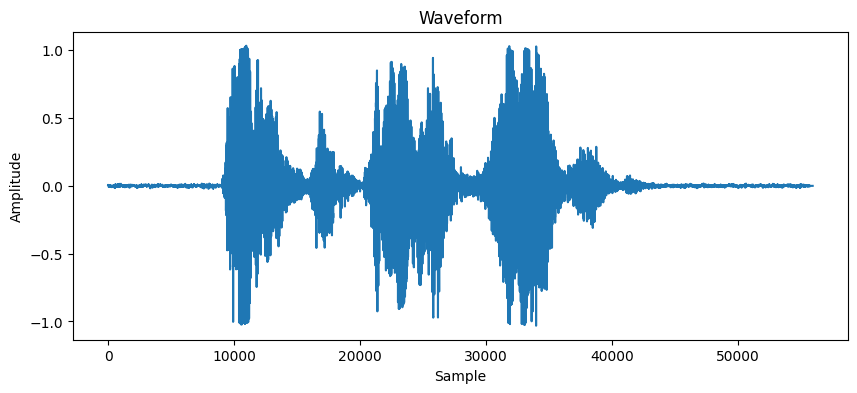

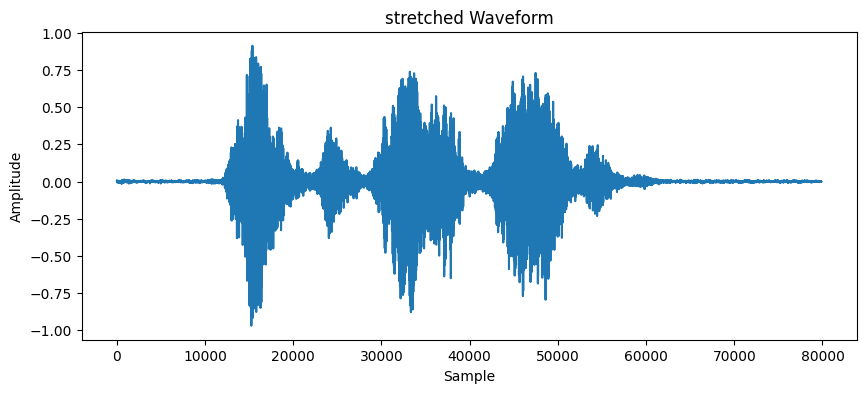

In [ ]:
# Stretch Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
Ag_st= stretch(data, rate=0.7)
Audio(Ag_st, rate=sample_rate)

# Stretch Data
plt.figure(figsize=(10, 4))
plt.plot(Ag_st)
plt.title('stretched Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

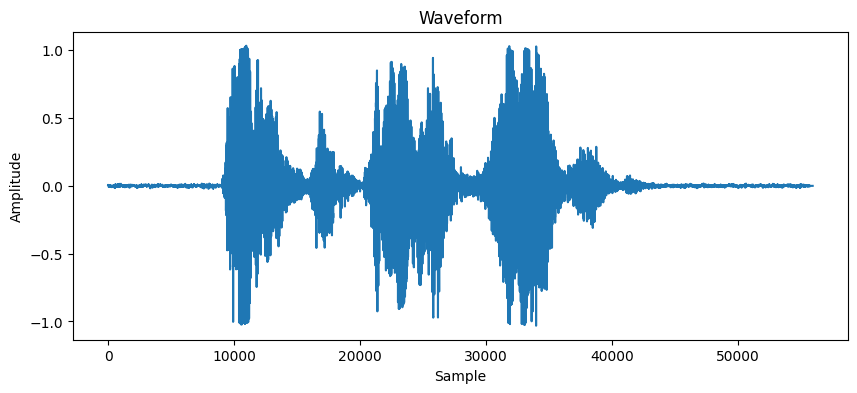

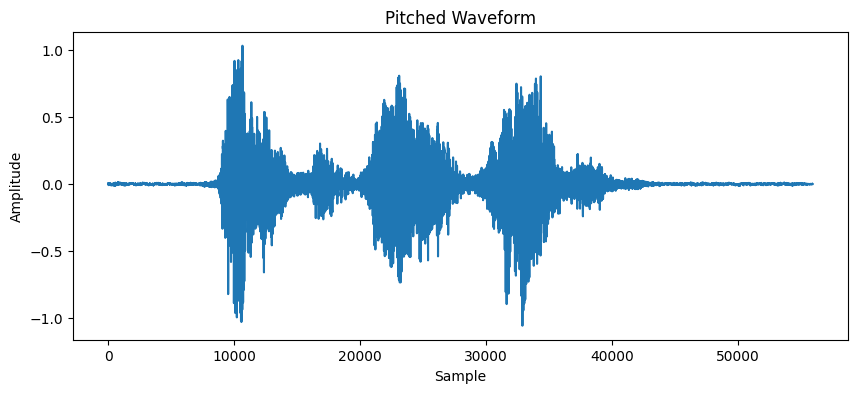

In [ ]:
# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
Ag_sc = pitch(data, pitch_factor=0.7)
Audio(Ag_sc, rate=sample_rate)

# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(Ag_sc)
plt.title('Pitched Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

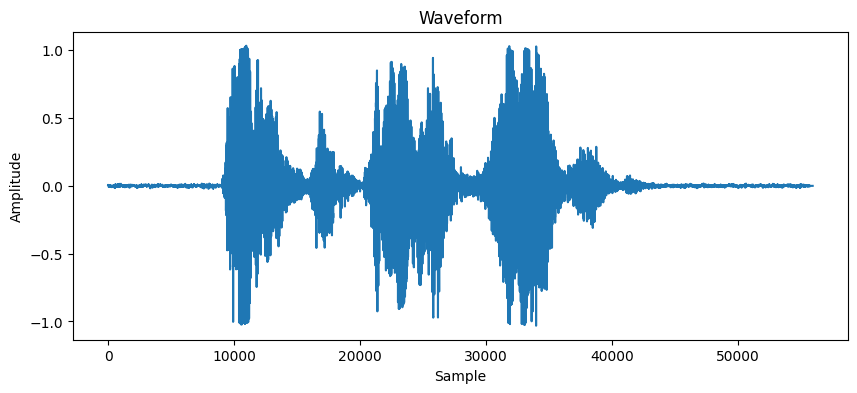

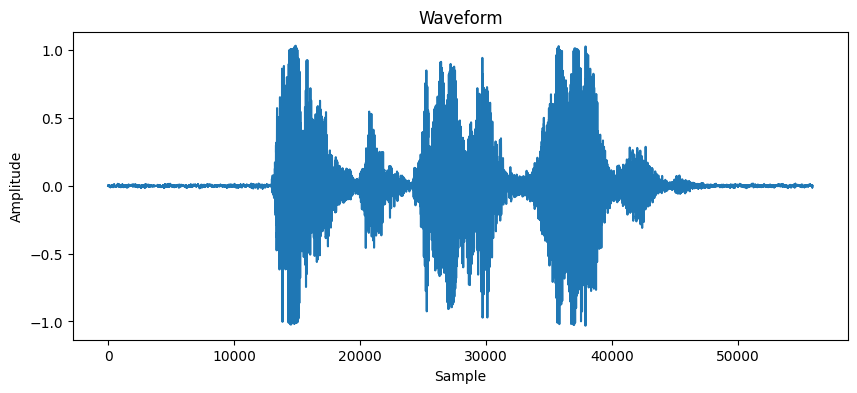

In [ ]:
# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Apply shift to the audio data
shifted_data = shift(data)

# Play the shifted audio
Audio(shifted_data, rate=sample_rate)

# Amplitude scaled Data
plt.figure(figsize=(10, 4))
plt.plot(shifted_data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

**Feautre Extraction**

---

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(Crema_df.Path[100])

array([-2.8555411e+02,  1.2049206e+02, -1.6643663e+01,  4.1877354e+01,
       -6.4962044e+00,  2.1643887e+00, -2.8035318e+01,  5.2555642e+00,
       -7.7527280e+00,  3.4441559e+00, -4.4781303e+00, -6.7129841e+00,
        9.2220306e+00, -7.2924409e+00,  3.2732396e+00, -8.3401680e+00,
       -3.5440199e+00, -6.4309120e+00, -1.2588555e+00, -6.9931746e+00,
       -3.7238328e+00, -6.8922567e-01, -6.5523257e+00, -6.6113341e-01,
       -1.6452968e+00,  4.3221679e+00, -4.1887197e-01,  2.1999202e+00,
       -4.0927143e+00,  1.1927364e+00, -1.7052670e+00, -4.5846705e+00,
       -5.2702701e-01, -6.2238688e+00, -7.4646676e-01, -2.8239086e+00,
        7.9684444e-02, -1.5343150e-02,  3.9648964e+00,  4.1059055e+00],
      dtype=float32)

In [ ]:
X_mfcc = Crema_df['Path'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

0       [-393.48068, 138.13977, -0.37868935, 47.858753...
1       [-267.3183, 119.5722, -33.70315, 44.494274, -1...
2       [-352.60196, 97.99767, -3.6843925, 54.8499, -1...
3       [-405.20273, 126.892914, -6.5530343, 75.05676,...
4       [-352.08856, 130.64432, -9.575907, 50.68427, -...
                              ...                        
7437    [-403.52527, 153.54613, 0.078538164, 43.51793,...
7438    [-397.22668, 133.28049, 17.786709, 51.57892, -...
7439    [-369.31247, 131.20274, 5.4154515, 51.89004, -...
7440    [-328.42282, 110.86818, 2.3822556, 48.353325, ...
7441    [-449.66776, 141.29942, 9.846713, 76.295395, -...
Name: Path, Length: 7442, dtype: object

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(7442, 40)

In [ ]:
X

array([[-3.9348068e+02,  1.3813977e+02, -3.7868935e-01, ...,
        -5.3399169e-01,  8.8730395e-01, -3.1136820e+00],
       [-2.6731830e+02,  1.1957220e+02, -3.3703152e+01, ...,
         2.3787162e+00, -2.1820685e-01, -1.2638432e+00],
       [-3.5260196e+02,  9.7997673e+01, -3.6843925e+00, ...,
        -2.4721861e+00,  1.2835011e+00, -2.1016282e-01],
       ...,
       [-3.6931247e+02,  1.3120274e+02,  5.4154515e+00, ...,
        -4.8610887e-01,  2.6519361e+00,  3.1393975e-01],
       [-3.2842282e+02,  1.1086818e+02,  2.3822556e+00, ...,
        -8.1839502e-02,  5.5651188e+00,  4.7116950e-01],
       [-4.4966776e+02,  1.4129942e+02,  9.8467131e+00, ...,
        -1.6039106e+00,  3.5114954e+00, -5.4086393e-01]], dtype=float32)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(Crema_df[['Emotions']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

(7442, 6)

**Train Test** **Split**

---



In [ ]:

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.75, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5581, 40), (5581, 6), (1396, 40), (1396, 6), (465, 40), (465, 6))

In [ ]:
# Scale the data using StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5581, 40), (5581, 6), (1396, 40), (1396, 6), (465, 40), (465, 6))

In [ ]:

# Expand dimensions for model compatibility
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5581, 40, 1), (5581, 6), (1396, 40, 1), (1396, 6), (465, 40, 1), (465, 6))

**Model Building**

---



**Keras Tuner Optimizer**

---



In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import LeakyReLU

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(hp.Int('conv1_units', min_value=32, max_value=512, step=32), kernel_size=5, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv1D(hp.Int('conv2_units', min_value=32, max_value=512, step=32), kernel_size=5, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv1D(hp.Int('conv3_units', min_value=32, max_value=512, step=32), kernel_size=5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv1D(hp.Int('conv4_units', min_value=32, max_value=512, step=32), kernel_size=5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=256, step=16)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_directory',
    project_name='my_project'
)

tuner.search_space_summary()


Search space summary
Default search space size: 9
conv1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
conv3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv4_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 25

Validation Dataset

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Train the model with Keras Tuner
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping , rlrp])

Trial 10 Complete [00h 01m 07s]
val_accuracy: 0.47526881098747253

Best val_accuracy So Far: 0.47526881098747253
Total elapsed time: 00h 09m 45s


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Retrieve the best model found by Keras Tuner
best_model_cnn = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model_cnn.summary()

# Compile the best model with the optimal hyperparameters
best_model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Apply Early Stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)

# Train the model with callbacks
history = best_model_cnn.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 160)           960       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 40, 160)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 160)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 160)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 448)           358848    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 20, 448)           0         
                                                        

In [ ]:
loss, accuracy = best_model_cnn.evaluate(x_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


15/15 [==============================] - 0s 5ms/step - loss: 1.4013 - accuracy: 0.4688
Validation Loss: 1.401315689086914
Validation Accuracy: 0.46881720423698425


15/15 [==============================] - 0s 5ms/step - loss: 1.4013 - accuracy: 0.4688
Accuracy of our model on validation data :  46.881720423698425 %


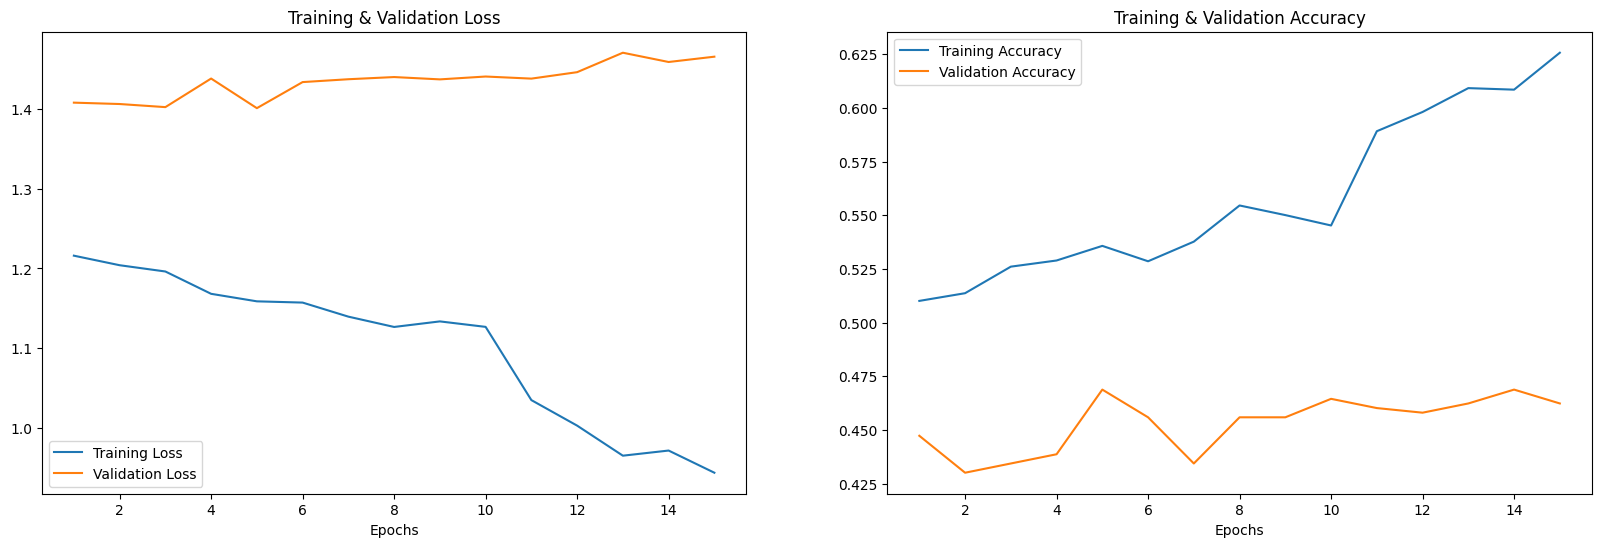

In [ ]:
print("Accuracy of our model on validation data : " , best_model_cnn.evaluate(x_val,y_val)[1]*100 , "%")

# Get the number of epochs from the history
epochs = range(1, len(history.history['loss']) + 1)
#epochs = [i for i in range(11)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Test Dataset

In [ ]:
import shutil
# Clear tuner directory
shutil.rmtree('my_directory', ignore_errors=True)

In [ ]:
tuner_test = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_directory',
    project_name='my_project'
)

tuner_test.search_space_summary()


Search space summary
Default search space size: 9
conv1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
conv3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv4_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 25

In [ ]:
# Train the model with Keras Tuner
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner_test.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping , rlrp])

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.4563037157058716

Best val_accuracy So Far: 0.467048704624176
Total elapsed time: 00h 10m 51s


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Retrieve the best model found by Keras Tuner
best_model_cnn = tuner_test.get_best_models(num_models=1)[0]
best_hyperparameters = tuner_test.get_best_hyperparameters(num_trials=1)[0]

best_model_cnn.summary()

# Compile the best model with the optimal hyperparameters
best_model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Apply Early Stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)

# Train the model with callbacks
history = best_model_cnn.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            192       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 40, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 480)           77280     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 20, 480)           0         
                                                        

In [ ]:
loss, accuracy = best_model_cnn.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


44/44 [==============================] - 0s 4ms/step - loss: 1.3671 - accuracy: 0.4556
Test Loss: 1.3671362400054932
Test Accuracy: 0.45558738708496094


44/44 [==============================] - 0s 4ms/step - loss: 1.3671 - accuracy: 0.4556
Accuracy of our model on test data :  45.558738708496094 %


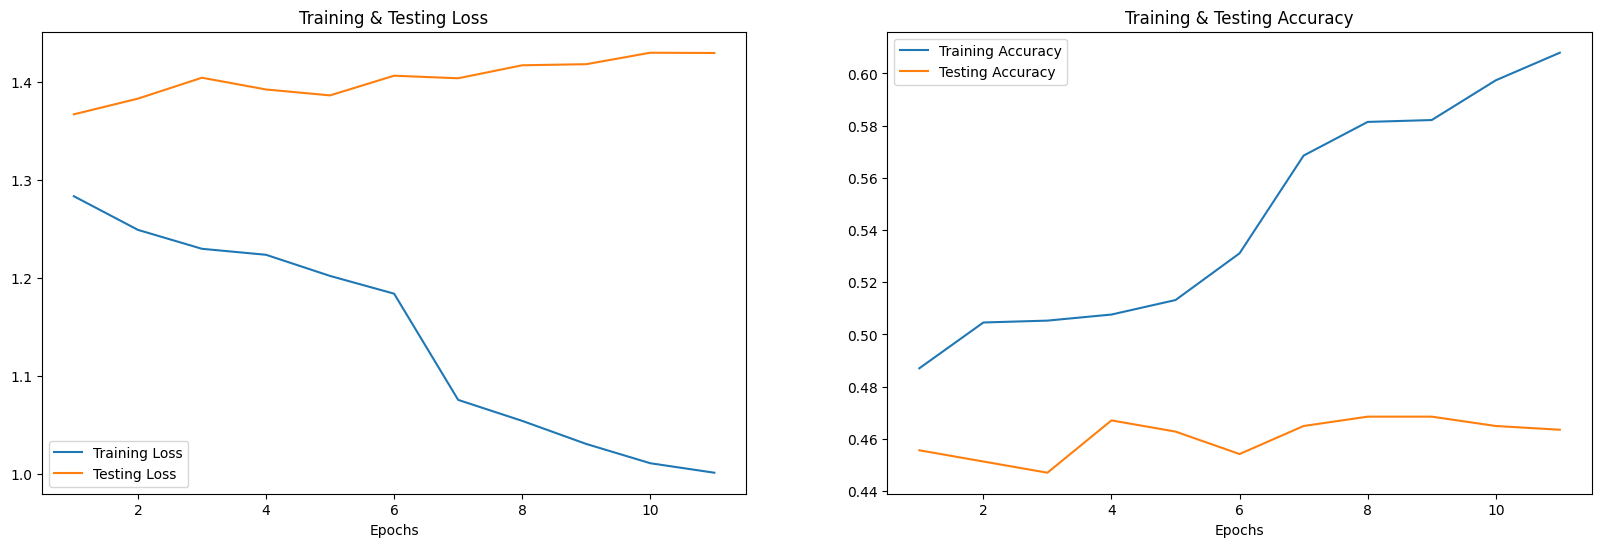

In [ ]:
print("Accuracy of our model on test data : " , best_model_cnn.evaluate(x_test,y_test)[1]*100 , "%")

# Get the number of epochs from the history
epochs = range(1, len(history.history['loss']) + 1)
#epochs = [i for i in range(11)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = best_model_cnn.predict(x_test)
y_pred_cnn = enc.inverse_transform(pred_test)

y_test_cnn = enc.inverse_transform(y_test)

44/44 [==============================] - 0s 2ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_cnn.flatten()
df['Actual Labels'] = y_test_cnn.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,sad,fear
2,sad,neutral
3,sad,neutral
4,neutral,neutral
5,angry,angry
6,disgust,disgust
7,happy,disgust
8,sad,sad
9,sad,fear


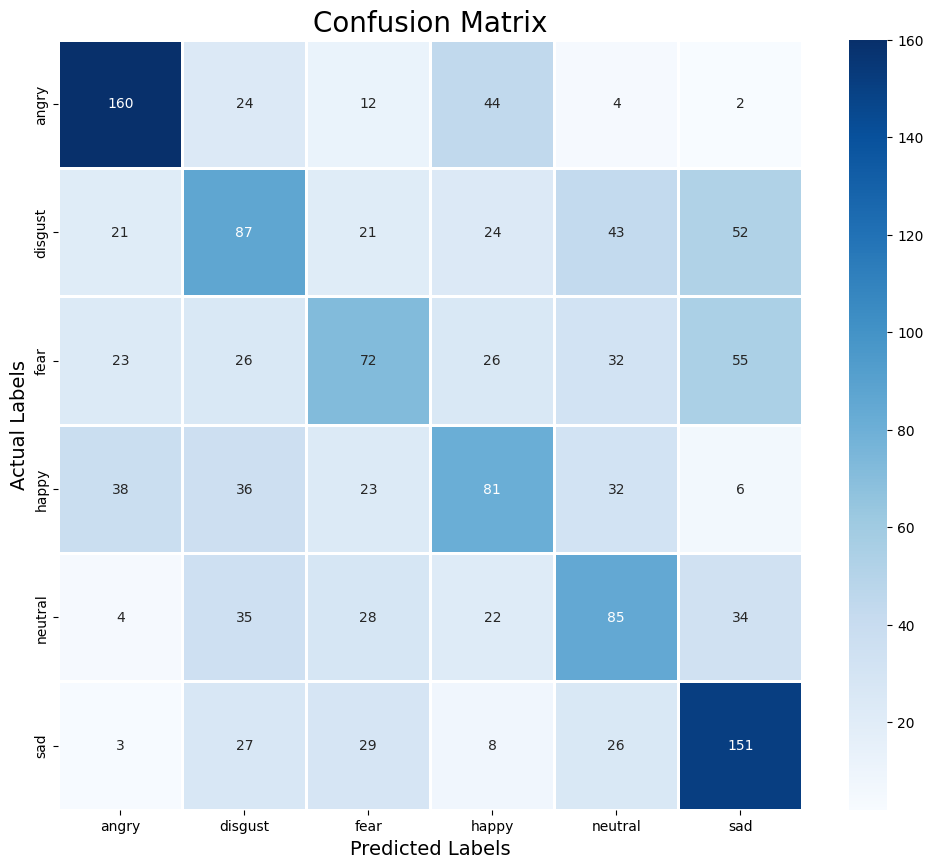

In [ ]:
cm = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_cnn, y_pred_cnn))


              precision    recall  f1-score   support

       angry       0.64      0.65      0.65       246
     disgust       0.37      0.35      0.36       248
        fear       0.39      0.31      0.34       234
       happy       0.40      0.38      0.38       216
     neutral       0.38      0.41      0.40       208
         sad       0.50      0.62      0.56       244

    accuracy                           0.46      1396
   macro avg       0.45      0.45      0.45      1396
weighted avg       0.45      0.46      0.45      1396



LSTM From Keras Tuner

In [7]:
import os
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split

In [42]:
# Assuming 'Crema_df' is already created as per your previous code

# Function to extract raw audio data from the file path
def extract_audio(file_path, duration=2.0):
    audio_data, sample_rate = librosa.load(file_path, duration=duration, sr=None)
    return audio_data

In [43]:
extract_audio(Crema_df.Path[100])

array([ 7.9345703e-04, -9.1552734e-05, -3.3569336e-04, ...,
        0.0000000e+00,  0.0000000e+00,  3.0517578e-05], dtype=float32)

In [44]:
X_audio = Crema_df['Path'].apply(lambda x: extract_audio(x))

In [45]:
X_audio

0       [-0.0016479492, -0.00036621094, 0.0005187988, ...
1       [-0.0030822754, -0.0035095215, -0.0039367676, ...
2       [0.0010070801, 0.00045776367, -0.00033569336, ...
3       [0.005126953, 0.0047912598, 0.004547119, 0.004...
4       [0.0025939941, 0.0028381348, 0.0028686523, 0.0...
                              ...                        
7437    [0.004638672, 0.005340576, 0.004180908, 0.0041...
7438    [-0.00021362305, 0.0002746582, 0.00039672852, ...
7439    [-0.008361816, -0.008026123, -0.008544922, -0....
7440    [-9.1552734e-05, -0.00076293945, 6.1035156e-05...
7441    [-0.003540039, -0.004760742, -0.0062561035, -0...
Name: Path, Length: 7442, dtype: object

In [46]:
# Convert the Series to a list and then to a 2D array
X = np.array(X_audio.tolist())
X.shape

(7442,)

In [47]:
# Define the maximum length for padding
max_length = 20  # Adjust this value based on your desired audio length

# Create a new array to store the padded audio samples
X_padded = np.zeros((X.shape[0], max_length), dtype=np.float32)

# Pad the audio samples
for i, audio_data in enumerate(X):
    length = len(audio_data)
    if length <= max_length:
        X_padded[i, :length] = audio_data
    else:
        X_padded[i, :] = audio_data[:max_length]

# Now X_padded is a 2D array with shape (number_of_samples, max_length)
# where all audio samples have the same length (max_length).
print(X_padded.shape)


(7442, 20)


In [48]:
X_padded

array([[-1.64794922e-03, -3.66210938e-04,  5.18798828e-04, ...,
         4.42504883e-03,  4.05883789e-03,  3.23486328e-03],
       [-3.08227539e-03, -3.50952148e-03, -3.93676758e-03, ...,
        -1.31225586e-03, -6.10351562e-04,  2.44140625e-04],
       [ 1.00708008e-03,  4.57763672e-04, -3.35693359e-04, ...,
        -6.89697266e-03, -7.44628906e-03, -8.45336914e-03],
       ...,
       [-8.36181641e-03, -8.02612305e-03, -8.54492188e-03, ...,
        -2.74658203e-03, -2.50244141e-03, -2.07519531e-03],
       [-9.15527344e-05, -7.62939453e-04,  6.10351562e-05, ...,
        -2.47192383e-03, -2.13623047e-03, -2.80761719e-03],
       [-3.54003906e-03, -4.76074219e-03, -6.25610352e-03, ...,
        -1.07421875e-02, -1.01318359e-02, -9.70458984e-03]], dtype=float32)

In [49]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(Crema_df[['Emotions']])

In [50]:
y = y.toarray()

In [51]:
y.shape

(7442, 6)

**Train Test Split**

---



In [52]:
# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.25, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.75, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape


((5581, 20), (5581, 6), (1396, 20), (1396, 6), (465, 20), (465, 6))

In [53]:
# Scale the data using StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5581, 20), (5581, 6), (1396, 20), (1396, 6), (465, 20), (465, 6))

In [54]:
# Expand dimensions for model compatibility
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Expanded dimensions:")
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Testing set shape:", x_test.shape, y_test.shape)


Expanded dimensions:
Training set shape: (5581, 20, 1) (5581, 6)
Validation set shape: (465, 20, 1) (465, 6)
Testing set shape: (1396, 20, 1) (1396, 6)


**Model Building**

---



**Keras Tuner Optimizer**

In [85]:
!pip install keras-tuner

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
import shutil

def build_model_lstm(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=32),
                   return_sequences=False, input_shape=(20, 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_1', min_value=64, max_value=256, step=32)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_2', min_value=32, max_value=128, step=16)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_3', min_value=16, max_value=64, step=16)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [87]:
# Clear tuner directory
shutil.rmtree('my_directory', ignore_errors=True)

In [88]:
# Set up Keras Tuner RandomSearch
tuner_lstm = RandomSearch(
    build_model_lstm,
    objective='val_accuracy',
    max_trials=10,
    directory='my_directory',
    project_name='my_project'
)
tuner_lstm.search_space_summary()

Search space summary
Default search space size: 8
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_4 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5

Validation set

In [89]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner_lstm.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping, rlrp])

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.18924731016159058

Best val_accuracy So Far: 0.20430107414722443
Total elapsed time: 00h 05m 18s


In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Retrieve the best model found by Keras Tuner
build_model_lstm = tuner_lstm.get_best_models(num_models=1)[0]
best_hyperparameters = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

build_model_lstm.summary()

# Compile the best model with the optimal hyperparameters
build_model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Apply Early Stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)

# Train the model with callbacks
history = build_model_lstm.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 160)               20640     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 160)               0         
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 80)                0

In [91]:
loss, accuracy = build_model_lstm.evaluate(x_val, y_val)
print("Val Loss:", loss)
print("Val Accuracy:", accuracy)


15/15 [==============================] - 0s 5ms/step - loss: 1.7913 - accuracy: 0.1871
Val Loss: 1.791272759437561
Val Accuracy: 0.18709677457809448


15/15 [==============================] - 0s 6ms/step - loss: 1.7913 - accuracy: 0.1871
Accuracy of our model on test data :  18.70967745780945 %


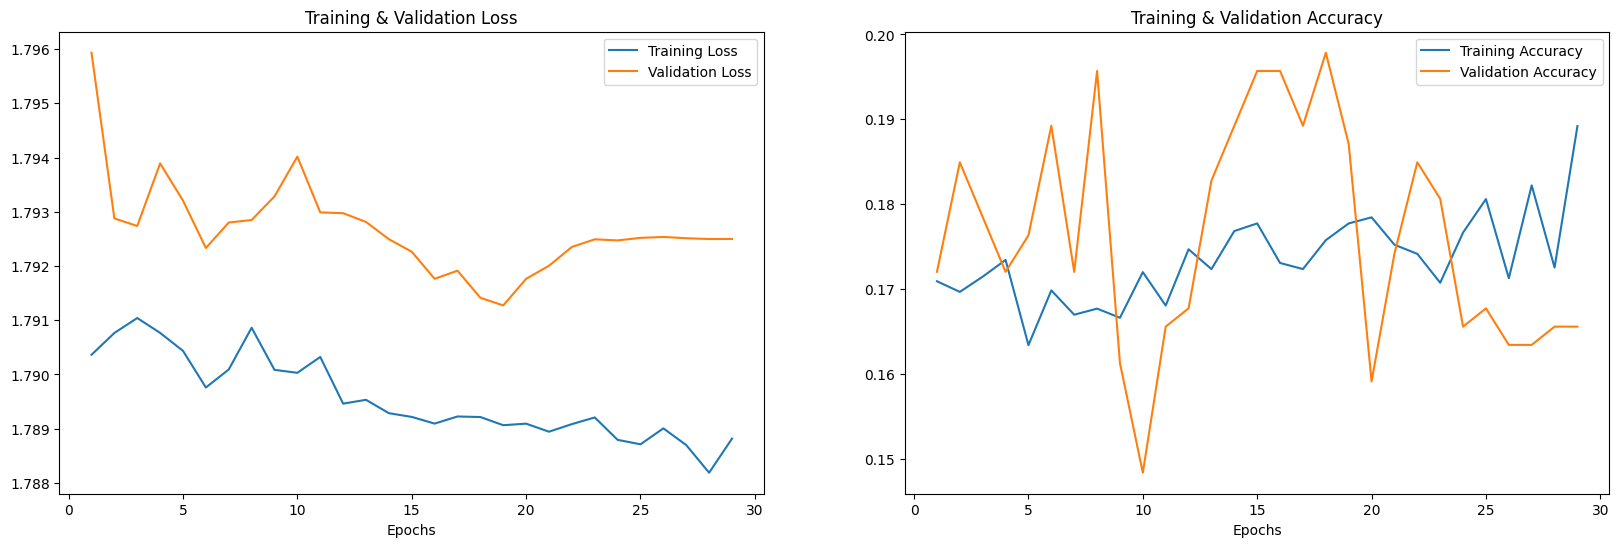

In [92]:
print("Accuracy of our model on test data : " , build_model_lstm.evaluate(x_val,y_val)[1]*100 , "%")

# Get the number of epochs from the history
epochs = range(1, len(history.history['loss']) + 1)
#epochs = [i for i in range(11)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Test Dataset

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
import shutil

def build_model_lstm_test(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=32),
                   return_sequences=False, input_shape=(20, 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_1', min_value=64, max_value=256, step=32)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_2', min_value=32, max_value=128, step=16)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units_3', min_value=16, max_value=64, step=16)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [94]:
from kerastuner.tuners import RandomSearch
# Set up Keras Tuner RandomSearch
tuner_lstm = RandomSearch(
    build_model_lstm_test,
    objective='val_accuracy',
    max_trials=10,
    directory='my_directory',
    project_name='my_project'
)
tuner_lstm.search_space_summary()

Search space summary
Default search space size: 8
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_4 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5

In [95]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner_lstm.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, rlrp])

In [96]:
# Train the model with Keras Tuner

# Get the best model and hyperparameters
build_model_lstm_test = tuner_lstm.get_best_models(num_models=1)[0]
best_hyperparameters_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

# Compile the best model with the optimal hyperparameters
build_model_lstm_test.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the best model on the full training set with callbacks
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_lstm = build_model_lstm_test.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping, rlrp])


Epoch 1/100
175/175 [==============================] - 5s 10ms/step - loss: 1.7904 - accuracy: 0.1799 - val_loss: 1.7909 - val_accuracy: 0.1812 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 7ms/step - loss: 1.7928 - accuracy: 0.1697 - val_loss: 1.7910 - val_accuracy: 0.1698 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 7ms/step - loss: 1.7907 - accuracy: 0.1709 - val_loss: 1.7916 - val_accuracy: 0.1569 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 7ms/step - loss: 1.7908 - accuracy: 0.1708 - val_loss: 1.7911 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 1s 7ms/step - loss: 1.7916 - accuracy: 0.1691 - val_loss: 1.7906 - val_accuracy: 0.1819 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 1s 8ms/step - loss: 1.7910 - accuracy: 0.1731 - val_loss: 1.7914 - val_accuracy: 0.1669 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 2s 10ms/

In [97]:
loss, accuracy = build_model_lstm_test.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


44/44 [==============================] - 0s 3ms/step - loss: 1.7906 - accuracy: 0.1819
Test Loss: 1.7906118631362915
Test Accuracy: 0.18194842338562012


15/15 [==============================] - 0s 5ms/step - loss: 1.7913 - accuracy: 0.1871
Accuracy of our model on test data :  18.70967745780945 %


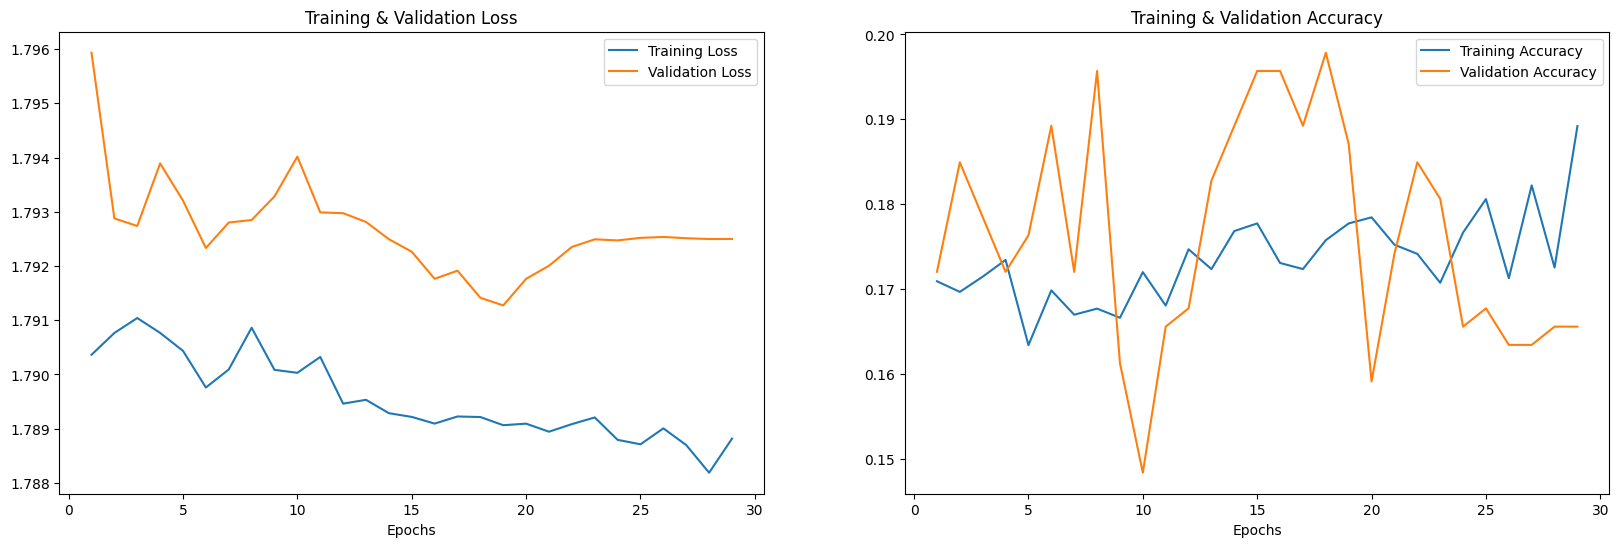

In [102]:
print("Accuracy of our model on test data : " , build_model_lstm.evaluate(x_val,y_val)[1]*100 , "%")

# Get the number of epochs from the history
epochs = range(1, len(history.history['loss']) + 1)
#epochs = [i for i in range(11)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [103]:
# predicting on test data.
pred_test = build_model_lstm_test.predict(x_test)
y_pred = enc.inverse_transform(pred_test)

y_test = enc.inverse_transform(y_test)

44/44 [==============================] - 1s 4ms/step


In [104]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


,Predicted Labels,Actual Labels
0,sad,neutral
1,happy,fear
2,fear,neutral
3,fear,neutral
4,happy,neutral
5,sad,angry
6,sad,disgust
7,disgust,disgust
8,sad,sad
9,fear,fear


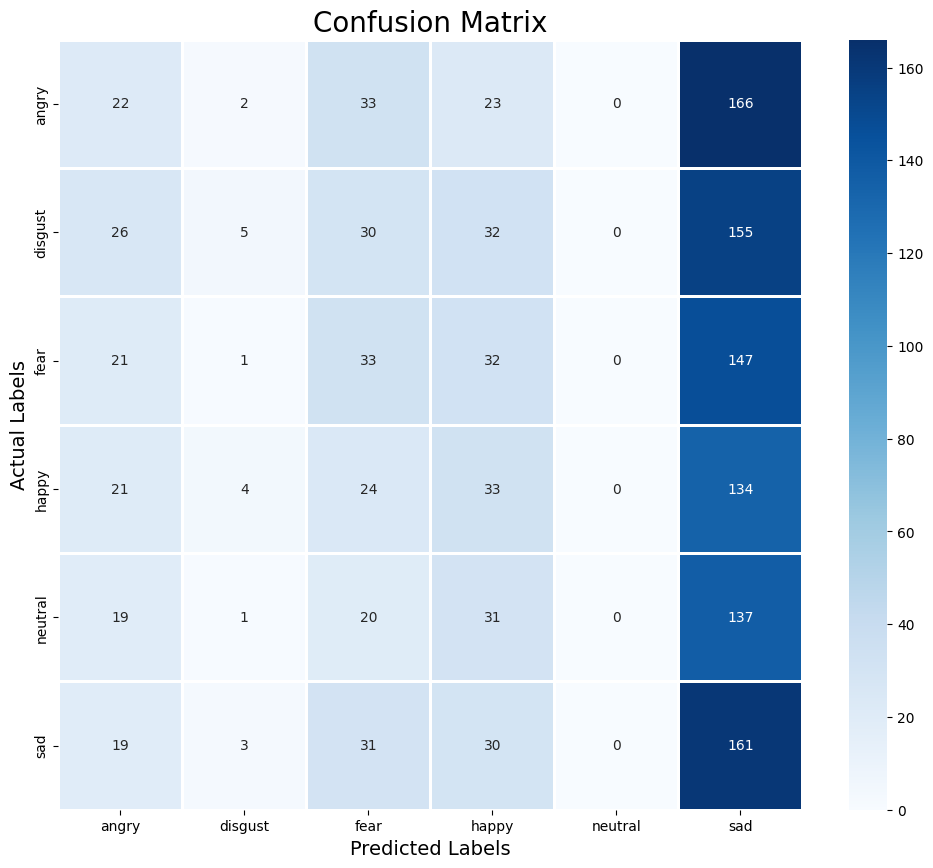

In [105]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [106]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.17      0.09      0.12       246
     disgust       0.31      0.02      0.04       248
        fear       0.19      0.14      0.16       234
       happy       0.18      0.15      0.17       216
     neutral       0.00      0.00      0.00       208
         sad       0.18      0.66      0.28       244

    accuracy                           0.18      1396
   macro avg       0.17      0.18      0.13      1396
weighted avg       0.18      0.18      0.13      1396

